In [1]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 663kB/s 


In [2]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [3]:
df = pd.read_csv('./dataset.csv')

df.tail(100)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
537477,1004728,P00354942,M,26-35,19,B,3,0,8,NaN,NaN,8007
537478,1004728,P00265242,M,26-35,19,B,3,0,5,8.0,NaN,6887
537479,1004728,P00071442,M,26-35,19,B,3,0,15,17.0,NaN,21533
537480,1004728,P00090942,M,26-35,19,B,3,0,1,2.0,14.0,15871
537481,1004728,P00003442,M,26-35,19,B,3,0,4,5.0,8.0,3539
537482,1004728,P00284642,M,26-35,19,B,3,0,5,8.0,NaN,7185
537483,1004728,P00048742,M,26-35,19,B,3,0,5,NaN,NaN,5160
537484,1004728,P00043642,M,26-35,19,B,3,0,5,NaN,NaN,7056
537485,1004728,P00321942,M,26-35,19,B,3,0,5,NaN,NaN,7192
537486,1004728,P00205642,M,26-35,19,B,3,0,5,8.0,NaN,6908


In [4]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [5]:
n_User_id = len(set(df.User_ID))

In [6]:
total_purchase = df.groupby(by=['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']).agg({'Purchase':sum})
total_purchase = total_purchase.reset_index(level=['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status'])
total_purchase.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase
User_ID,,,,,,,
1000001,F,0-17,10,A,2,0,333481
1000002,M,55+,16,C,4+,0,810353
1000003,M,26-35,15,A,3,0,341635
1000004,M,46-50,7,B,2,1,205987
1000005,M,26-35,20,A,1,1,821001


In [7]:
pc_count = pd.DataFrame( [[0]*18] * n_User_id, columns=list(range(1,19)), index=set(df.User_ID))

def def_count(v):
    def count(n):
        return sum(n==v)
    return count

agg_f = { v:def_count(v) for v in range(1,19)}

pc_count_intermediate = df.groupby('User_ID').agg({f'Product_Category_{i}': agg_f for i in range(1,4)})

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [8]:
pc_count_intermediate.head()

Product_Category_1                               ...   \
                        1  2   3  4   5  6  7   8  9  10 ...    
User_ID                                                  ...    
1000001                  4  1  11  2   2  1  0   8  0  0 ...    
1000002                 31  1   0  0  13  6  0  25  0  0 ...    
1000003                 15  2   1  0   9  0  0   1  0  0 ...    
1000004                 13  0   0  0   0  0  0   0  0  0 ...    
1000005                 18  2   1  3  20  6  5  44  0  0 ...    

        Product_Category_3                                               
                        9    10   11   12   13   14   15   16   17   18  
User_ID                                                                  
1000001                2.0  0.0  0.0  5.0  0.0  1.0  0.0  1.0  1.0  0.0  
1000002                1.0  1.0  0.0  0.0  2.0  5.0  2.0  4.0  6.0  1.0  
1000003                0.0  0.0  2.0  0.0  0.0  2.0  1.0  1.0  0.0  2.0  
1000004                1.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  1.0  0.0  
1000005                0.0  1.0  0.0  1.0  0.0  1.0  1.0  7.0  1.0  0.0  

[5 rows x 54 columns]

In [9]:
for index, row in tqdm(pc_count_intermediate.iterrows(), total=len(pc_count_intermediate)):
    s = row.loc['Product_Category_1'] + row.loc['Product_Category_2'] + row.loc['Product_Category_3']
    pc_count.loc[index,:] = s

In [12]:
pc_count.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1000001,4.0,3.0,11.0,13.0,5.0,2.0,0.0,13.0,2.0,0.0,0.0,8.0,0.0,3.0,1.0,2.0,2.0,0.0
1000002,31.0,9.0,0.0,0.0,15.0,9.0,0.0,46.0,1.0,1.0,2.0,0.0,3.0,10.0,7.0,14.0,7.0,1.0
1000003,15.0,15.0,1.0,1.0,15.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0
1000004,13.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,5.0,3.0,1.0,0.0
1000005,18.0,5.0,2.0,4.0,26.0,9.0,5.0,57.0,0.0,1.0,5.0,2.0,4.0,13.0,6.0,21.0,2.0,0.0
1000006,8.0,5.0,6.0,12.0,21.0,1.0,0.0,14.0,1.0,0.0,0.0,10.0,0.0,20.0,0.0,2.0,2.0,4.0
1000007,14.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,2.0,7.0,7.0,1.0,0.0
1000008,22.0,6.0,2.0,0.0,9.0,6.0,0.0,55.0,0.0,0.0,1.0,1.0,2.0,19.0,9.0,14.0,4.0,0.0
1000009,11.0,2.0,5.0,4.0,13.0,13.0,1.0,29.0,1.0,1.0,0.0,0.0,1.0,7.0,3.0,18.0,4.0,0.0
1000010,46.0,42.0,18.0,37.0,101.0,6.0,1.0,64.0,16.0,1.0,11.0,19.0,5.0,27.0,33.0,9.0,8.0,3.0


In [11]:
pc_count_L2 = pc_count.div(np.sqrt(pc_count.pow(2).sum(axis=1)), axis=0)
pc_count_L2.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1000001,0.163436,0.122577,0.449448,0.531166,0.204294,0.081718,0.000000,0.531166,0.081718,0.000000,0.000000,0.326871,0.000000,0.122577,0.040859,0.081718,0.081718,0.000000
1000002,0.498060,0.144598,0.000000,0.000000,0.240997,0.144598,0.000000,0.739057,0.016066,0.016066,0.032133,0.000000,0.048199,0.160665,0.112465,0.224930,0.112465,0.016066
1000003,0.548821,0.548821,0.036588,0.036588,0.548821,0.000000,0.000000,0.219529,0.000000,0.000000,0.073176,0.000000,0.000000,0.109764,0.036588,0.073176,0.000000,0.146352
1000004,0.849837,0.261488,0.000000,0.000000,0.000000,0.065372,0.000000,0.130744,0.065372,0.000000,0.130744,0.000000,0.000000,0.130744,0.326860,0.196116,0.065372,0.000000
1000005,0.252149,0.070041,0.028017,0.056033,0.364216,0.126075,0.070041,0.798473,0.000000,0.014008,0.070041,0.028017,0.056033,0.182108,0.084050,0.294174,0.028017,0.000000


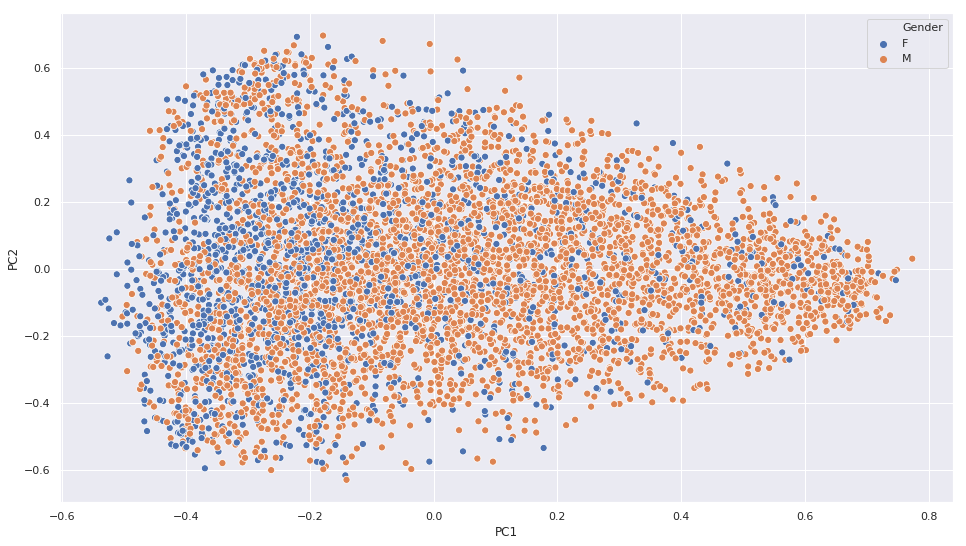

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(pc_count_L2)
pca = pd.DataFrame(pca, index = pc_count_L2.index
             , columns = ['PC1', 'PC2'])

plt.figure(figsize=(16, 9))
sns.scatterplot(x='PC1', y='PC2', hue=total_purchase['Gender'], s=50, data=pca)
plt.show()
#style=total_purchase['']

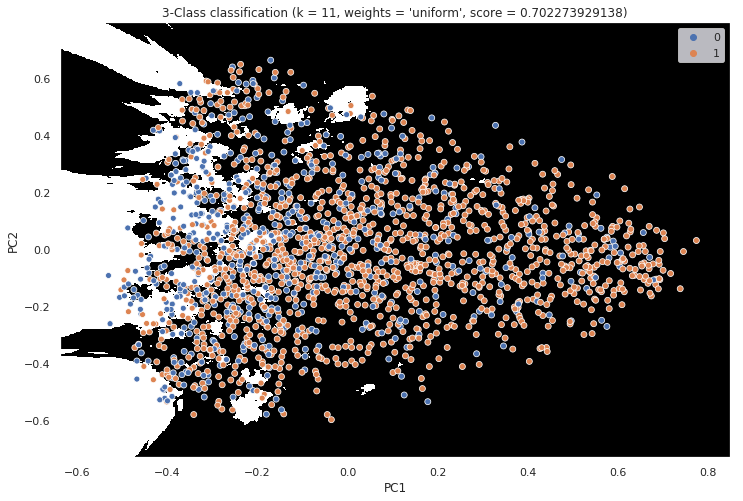

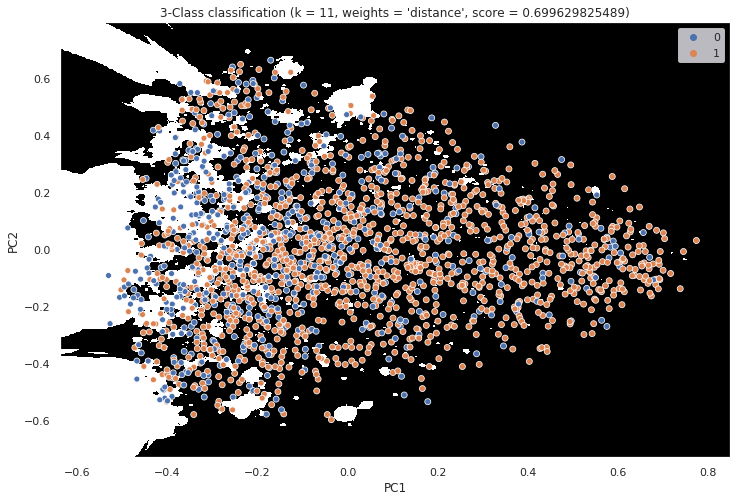

In [55]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

n_neighbors=13

def map_f(e):
    if e == 'F':
        return 0
    else:
        return 1

def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df


n_train = 4000

X, y = pca.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Gender'][:n_train]]
X_test, y_test = pca.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Gender'][n_train:]]

h = .0025  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFFFFFFF', '#00000000'])
cmap_bold = ListedColormap(['#FFFF00', '#00FFFF', '#0000FF'])

for n_neighbors in range(11,13, 2):
    for weights in ['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
        y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        
        #Z[:-1] = abs(Z[:-1] - Z[1:])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(12,8))

        # Plot also the training points
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=1)
        sns.scatterplot(X_test.iloc[:, 0], X_test.iloc[:, 1], hue=y_test)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        r = clf.score(X_test, y_test)
        plt.title("3-Class classification (k = %i, weights = '%s', score = %s)"
                  % (n_neighbors, weights, r))

plt.show()

In [63]:
def map_f(e):
    if e == 'F':
        return 0
    else:
        return 1

n_train = 4000

X, y = pc_count_L2.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Gender'][:n_train]]
X_test, y_test = pc_count_L2.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Gender'][n_train:]]

for n_neighbors in range(1,23, 2):
    for weights in ['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)
        r = clf.score(X_test, y_test)
        print("3-Class classification (k = %i, weights = '%s', score = %s)"
                  % (n_neighbors, weights, r))

3-Class classification (k = 1, weights = 'uniform', score = 0.696456901111)
3-Class classification (k = 1, weights = 'distance', score = 0.696456901111)
3-Class classification (k = 3, weights = 'uniform', score = 0.734531993654)
3-Class classification (k = 3, weights = 'distance', score = 0.734003172924)
3-Class classification (k = 5, weights = 'uniform', score = 0.736647276573)
3-Class classification (k = 5, weights = 'distance', score = 0.736118455843)
3-Class classification (k = 7, weights = 'uniform', score = 0.746166049709)
3-Class classification (k = 7, weights = 'distance', score = 0.74510840825)
3-Class classification (k = 9, weights = 'uniform', score = 0.748281332628)
3-Class classification (k = 9, weights = 'distance', score = 0.746694870439)
3-Class classification (k = 11, weights = 'uniform', score = 0.746694870439)
3-Class classification (k = 11, weights = 'distance', score = 0.74510840825)
3-Class classification (k = 13, weights = 'uniform', score = 0.747223691169)
3-Cla

In [99]:
import random
def create_sample(size, prop=0.7):
    train = random.sample(range(size), int(size*prop))
    val = [i for i in range(size) if i not in train]
    return (train, val)


([8, 5, 0, 7, 3], [1, 2, 4, 6, 9])

Score 0.7811704834605598


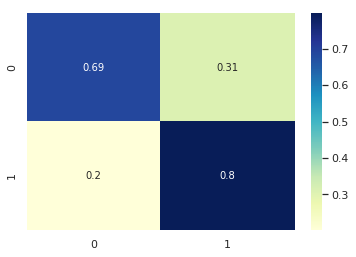

In [117]:
from sklearn.metrics import confusion_matrix

train, test = create_sample(len(pc_count_L2),0.8)
                      
X, y = pc_count_L2.iloc[train,:],  [map_f(e) for e in total_purchase['Gender'].iloc[train]]
X_test, y_test = pc_count_L2.iloc[test,:],  [map_f(e) for e in total_purchase['Gender'].iloc[test]]

n_neighbors = 9
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, y)
y_pred = clf.predict(X_test)
print(f'Score {clf.score(X_test, y_test)}')
conf = confusion_matrix(y_pred, y_test)
risk = (conf.transpose() / conf.sum(axis=1)).transpose()
sns.heatmap(risk, annot=True, cmap="YlGnBu")
plt.show()

In [112]:
pca_X_test = pca.iloc[n_train:,:]
plt.figure(figsize=(14,10))
data = {
    'x' : pca_X_test['PC1'],
    'y' : pca_X_test['PC2'],
    'Gender' : y_test,
    'Pred' : y_pred
}
sns.scatterplot(x='x', y='y', s=75, data=data, legend='full', hue='Gender', style='Pred')
plt.show()

ValueError: array length 1179 does not match index length 1891

<Figure size 1008x720 with 0 Axes>

## Augmenter le nombre de filles

In [59]:
X_fx2 = X
len(X_fx2)
#X[[e == 0 for e in y]]
females = X[[e == 0 for e in y]]
females.index = [ str(i) + '_2' for i in females.index]
X_fx2 = X_fx2.append(females)
y_fxy = y + [0] * len(females)

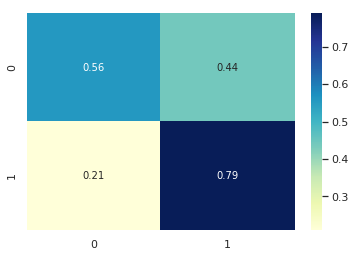

In [60]:
n_neighbors = 9
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X_fx2, y_fxy)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_pred, y_test)
risk = (conf.transpose() / conf.sum(axis=1)).transpose()
sns.heatmap(risk, annot=True, cmap="YlGnBu")
plt.show()

## Selection de variables

#### Variables corrélées

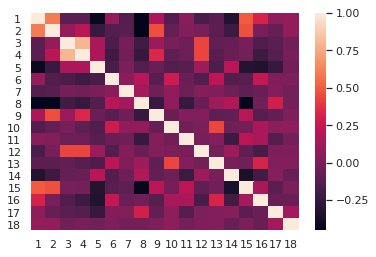

In [66]:
sns.heatmap(pc_count_L2.corr())

### Élimination de variables

([6, 8, 4, 0, 9], [1, 2, 3, 5, 7])

In [103]:
def map_f(e):
    if e == 'F':
        return 0
    else:
        return 1
    
def f(data, cols, train_index, val_index, d=1, best_n=3, best_v=0):
    if d <= 0:
        return (cols, best_v)
    weights = 'uniform'
    n_neighbors_range = list(range(5, 21, 2))
    results = dict()
    for i in tqdm(cols):
        cols_tmp = [c for c in cols if c != i]
        data_L2 = pc_count_L2.iloc[:, cols_tmp]
        X = data_L2.iloc[train_index,:]
        y = [map_f(e) for e in total_purchase['Gender'].iloc[train_index]]
        X_test = data_L2.iloc[val_index,:]
        y_test = [map_f(e) for e in total_purchase['Gender'].iloc[val_index]]
        best_score_neighbors = 0
        best_clf = None
        for n_neighbors in n_neighbors_range:
            clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
            clf.fit(X, y)
            score_neighbors = clf.score(X_test, y_test)
            if score_neighbors > best_score_neighbors:
                best_score_neighbors = score_neighbors
                best_clf = clf
        results[i] = best_score_neighbors
    resutls = list(results.items())
    resutls.sort(key = lambda x: x[1], reverse=True)
    resutls = resutls[:best_n]
    print(resutls)
    best_col = cols
    for i, res in resutls:
        cols_tmp = [c for c in cols if c != i]
        if res > best_v:
            best_col, best_v = f(data, cols_tmp, train_index, val_index, d=(d-1), best_n=best_n, best_v=res)
            

(train, val) = create_sample(n_train)
f(pc_count_L2, list(range(18)), train, val)

KeyboardInterrupt: 

In [103]:
n_train = 4000
n_neighbors = 9
weights = 'uniform'
n_sample = 5
(train, val) = create_sample(n_train)


cols = list(range(0,18))#[0, 1, 3, 7, 8, 9, 11, 12, 13, 14, 17]#
for n in tqdm(range(0,8)):
    best_i = 0
    best_score = 0
    for i in tqdm(cols):
        score = 0
        for sample_index in range(n_sample):
            cols_tmp = [c for c in cols if c != i]
            data_L2 = pc_count_L2.iloc[:, cols_tmp]
            #data_L2 = data.div(np.sqrt(data.pow(2).sum(axis=1)), axis=0)
            (train, val) = create_sample(n_train)
            X = data_L2.iloc[train,:]
            y = [map_f(e) for e in total_purchase['Gender'].iloc[train]]
            X_test = data_L2.iloc[val,:]
            y_test = [map_f(e) for e in total_purchase['Gender'].iloc[val]]
            best_score_neighbors = 0
            best_clf = None
            for n_neighbors in range(3,25,2):
                clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
                clf.fit(X, y)
                y_pred = clf.predict(X_test)
                conf = confusion_matrix(y_pred, y_test)
                risk = (conf.transpose() / conf.sum(axis=1)).transpose()
                score_neighbors = risk[0,0]*risk[1,1]
                if score_neighbors > best_score_neighbors:
                    best_score_neighbors = score_neighbors
                    best_clf = clf
            score += best_score_neighbors / n_sample
        #print(best_score_neighbors)
        if score > best_score:
            best_score = score
            best_i = i
        y_pred = best_clf.predict(X_test)
        conf = confusion_matrix(y_pred, y_test)
        risk = (conf.transpose() / conf.sum(axis=1)).transpose()
        #sns.heatmap(risk, annot=True, cmap="YlGnBu")
        #plt.show()
    print(best_score)
    print(best_i)
    cols = [c for c in cols if c != best_i]
    print(cols)

0.544679995711
11
[0, 1, 3, 7, 8, 9, 12, 13, 14, 17]


0.548090416898
1
[0, 3, 7, 8, 9, 12, 13, 14, 17]


0.553088072312
17
[0, 3, 7, 8, 9, 12, 13, 14]


0.55404664368
8
[0, 3, 7, 9, 12, 13, 14]


0.555089062557
14
[0, 3, 7, 9, 12, 13]


0.53683608831
9
[0, 3, 7, 12, 13]


0.521115742968
3
[0, 7, 12, 13]


0.49631340006
0
[7, 12, 13]


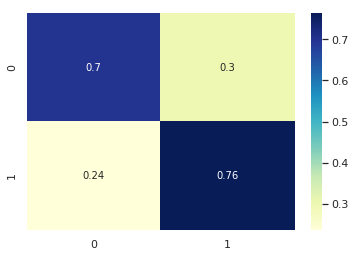

In [109]:
data_L2 = pc_count_L2.iloc[:, [0, 1, 3, 7, 8, 9, 11, 12, 13, 14, 17]]#[0, 2, 3, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17]]
X, y = data_L2.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Gender'][:n_train]]
X_test, y_test = data_L2.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Gender'][n_train:]]
n_neighbors = 17
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, y)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_pred, y_test)
risk = (conf.transpose() / conf.sum(axis=1)).transpose()
sns.heatmap(risk, annot=True, cmap="YlGnBu")
plt.show()

## SVM

In [86]:
pc_count_norm = pc_count.div(np.sqrt(pc_count.pow(2).sum(axis=0)), axis=1)
pc_count_norm = pc_count_norm.div(np.sqrt(pc_count_norm.pow(2).sum(axis=1)), axis=0)
pc_count_norm.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1000001,0.045806,0.066283,0.638065,0.442497,0.041472,0.076091,0.000000,0.110435,0.169781,0.000000,0.000000,0.570180,0.000000,0.063203,0.021412,0.037027,0.105436,0.000000
1000002,0.394426,0.220936,0.000000,0.000000,0.138235,0.380442,0.000000,0.434176,0.094319,0.156024,0.065938,0.000000,0.234066,0.234077,0.166533,0.287979,0.410016,0.131596
1000003,0.273054,0.526828,0.092208,0.054108,0.197775,0.000000,0.000000,0.081024,0.000000,0.000000,0.094338,0.000000,0.000000,0.100469,0.034037,0.058859,0.000000,0.753105
1000004,0.600111,0.356261,0.000000,0.000000,0.000000,0.153366,0.000000,0.068489,0.342204,0.000000,0.239232,0.000000,0.000000,0.169853,0.431576,0.223892,0.212513,0.000000
1000005,0.143930,0.077138,0.081006,0.095070,0.150582,0.239090,0.755724,0.338108,0.000000,0.098054,0.103597,0.099533,0.196133,0.191238,0.089707,0.271472,0.073622,0.000000


Score 0.7493389740877843


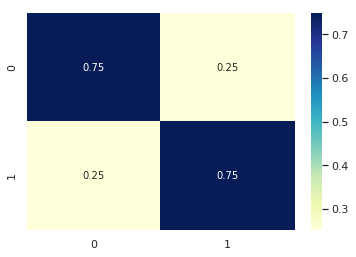

In [95]:
from sklearn import svm

X, y = pc_count_norm.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Gender'][:n_train]]
X_test, y_test = pc_count_norm.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Gender'][n_train:]]

clf = svm.SVC(gamma='scale', C=10)
clf.fit(X, y)
y_pred = clf.predict(X_test)
print(f'Score {clf.score(X_test, y_test)}')
conf = confusion_matrix(y_pred, y_test)
risk = (conf.transpose() / conf.sum(axis=1)).transpose()
sns.heatmap(risk, annot=True, cmap="YlGnBu")
plt.show()

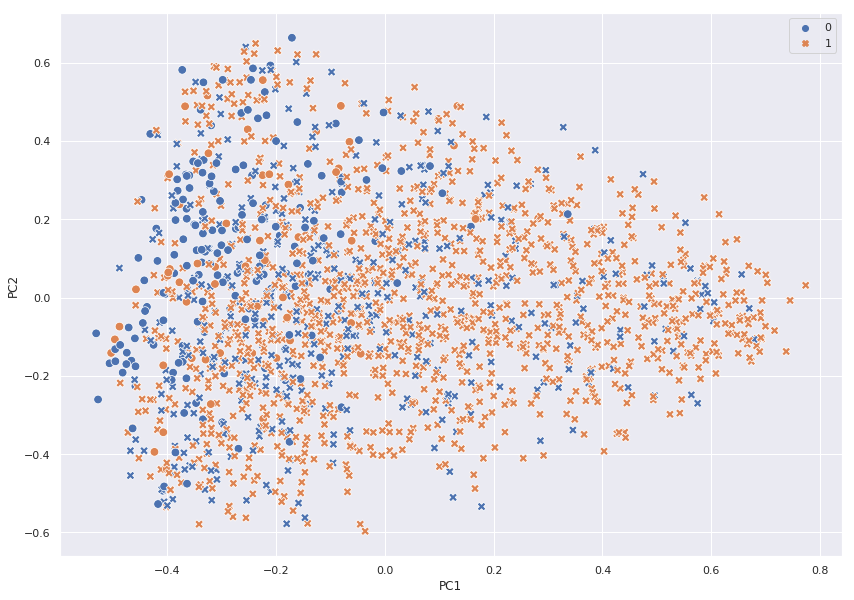

In [98]:
plt.figure(figsize=(14,10))
data = {
    'x' : pca_X_test['PC1'],
    'y' : pca_X_test['PC2'],
    'Gender' : y_test,
    'Pred' : y_pred
}
sns.scatterplot(x='x', y='y', s=75, data=data, legend='full', hue='Gender', style='Pred')
plt.show()

## Cat

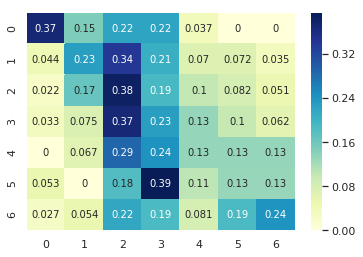

In [123]:
def map_f(e):
    if e == '0-17':
        return 0
    elif e == '18-25':
        return 1
    elif e == '26-35':
        return 2
    elif e == '36-45':
        return 3
    elif e == '46-50':
        return 4
    elif e == '51-55':
        return 5
    elif e == '55+':
        return 6
    else:
        return 40

n_train = 4000

X, y = pc_count_L2.iloc[:n_train,:],  [map_f(e) for e in total_purchase['Age'][:n_train]]
X_test, y_test = pc_count_L2.iloc[n_train:,:],  [map_f(e) for e in total_purchase['Age'][n_train:]]
n_neighbors = 9
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
#clf = svm.SVC(gamma='scale')
clf.fit(X, y)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_pred, y_test)
risk = (conf.transpose() / conf.sum(axis=1)).transpose()
sns.heatmap(risk, annot=True, cmap="YlGnBu")
plt.show()